### 

# Support vector machines

In [1]:
# import libraries

import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from matplotlib.backends.backend_pdf import PdfPages

from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.svm import LinearSVR
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import pairwise_kernels

from sklearn import model_selection

from sklearn.impute import KNNImputer
from sklearn.feature_selection import GenericUnivariateSelect, chi2

## Data pre-processing

In [2]:
# load training data

# load data from csv file
df_train_features = pd.read_csv ('train_features.csv')
df_train_labels = pd.read_csv('train_labels.csv')

# Load test data
df_test_features = pd.read_csv ('test_features.csv')

 ### Histogram of the output labels 

We should check for class imbalance.

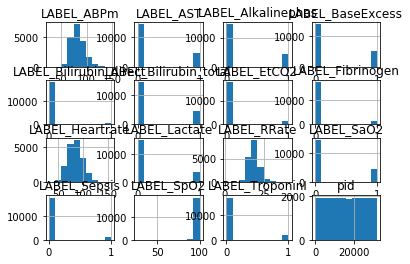

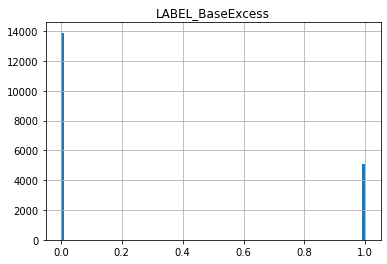

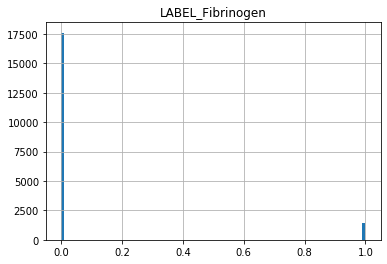

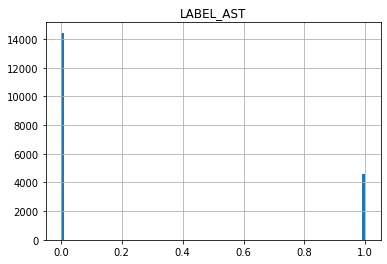

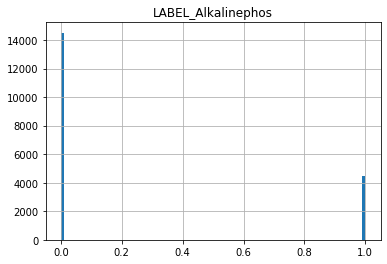

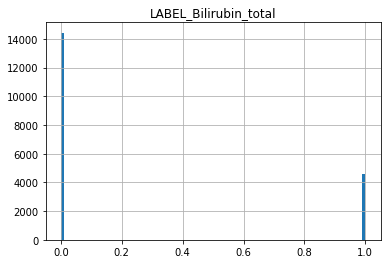

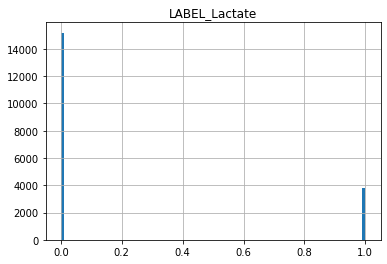

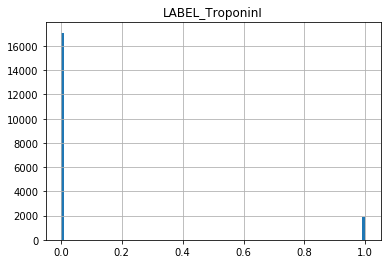

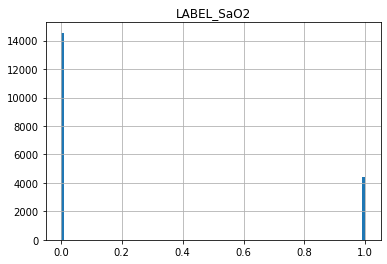

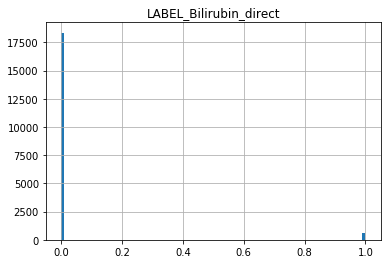

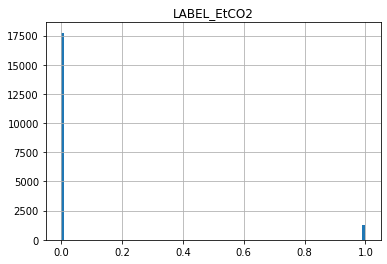

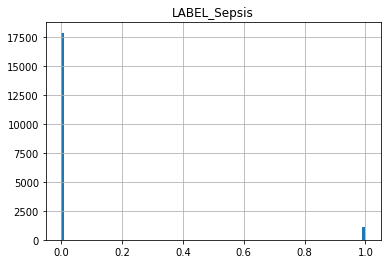

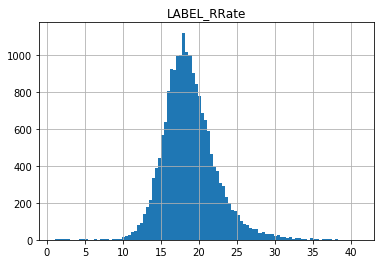

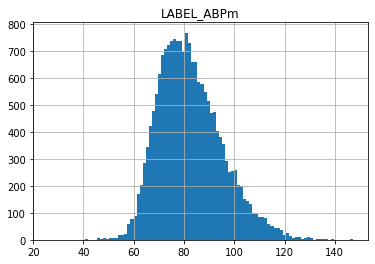

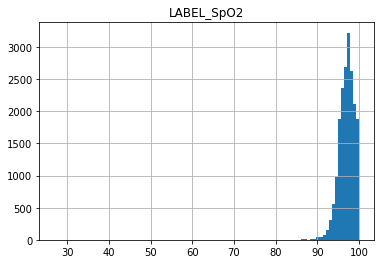

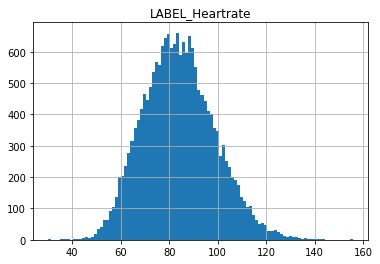

In [3]:
df_train_labels.hist()

with PdfPages("./Results/Labels_histogram.pdf") as export_pdf:
    for i in list(df_train_labels)[1:]:
        df_train_labels.hist(column = i, bins = 100)
        export_pdf.savefig()

One can see the class imbalance problem here. Other observations:
  * Heartrate, RRate, ABPm,  distribution is similar to a normal distribution
  * SpO2 is like a censored normal distribution. 
  * For all of the other features, class imbalance is an obvious problem.

A basic strategy that could be used here: Upsample both classes! Do the upsampling efficiently, not just replicating the datapoints

### Train Data pre-processing

       pid  Time    Age  EtCO2    PTT    BUN  Lactate  Temp   Hgb  HCO3  ...  \
min      1     1   15.0   10.0   12.5    1.0      0.2  21.0   3.3   0.0  ...   
max  31658   315  100.0  100.0  250.0  268.0     31.0  42.0  23.8  50.0  ...   

     Alkalinephos   SpO2  Bilirubin_direct  Chloride   Hct  Heartrate  \
min          12.0   20.0              0.01      66.0   9.4       23.0   
max        3833.0  100.0             21.20     141.0  63.4      191.0   

     Bilirubin_total  TroponinI   ABPs    pH  
min              0.1       0.01   21.0  6.82  
max             46.5     440.00  287.0  7.78  

[2 rows x 37 columns]


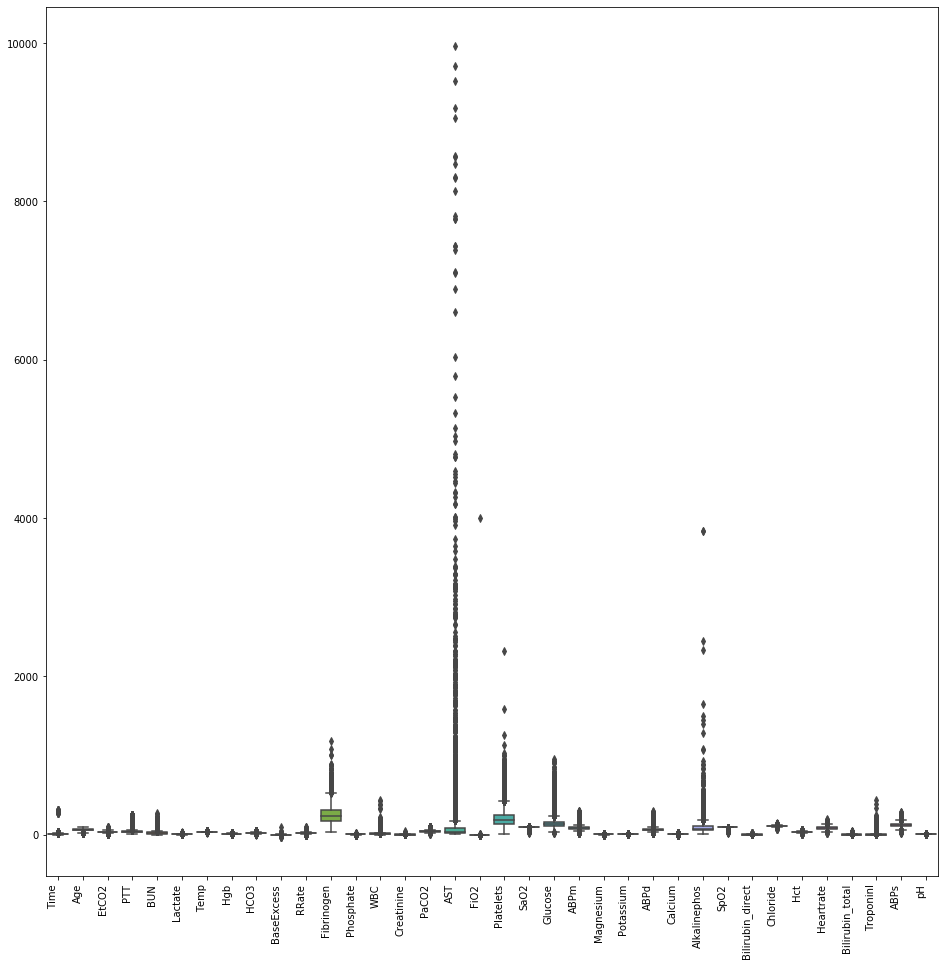

In [4]:
# data inspection: 
#############################################
# range of the provided data?
print(df_train_features.agg([min, max]))

# Boxplotting the data
# fig2, ax2 = plt.subplots()
# ax2.set_title('BUN')
# ax2.boxplot(df_train_features.iloc[:,5], notch=True)

plt.figure(figsize=(16, 16))
ax = sns.boxplot(data = df_train_features.iloc[:,1:])
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

# with PdfPages("./Results/Train_columns_boxplot.pdf") as export_pdf:
#     for i in list(df_train_labels)[1:]:
#         df_train_labels.hist(column = i, bins = 100)
#         export_pdf.savefig()

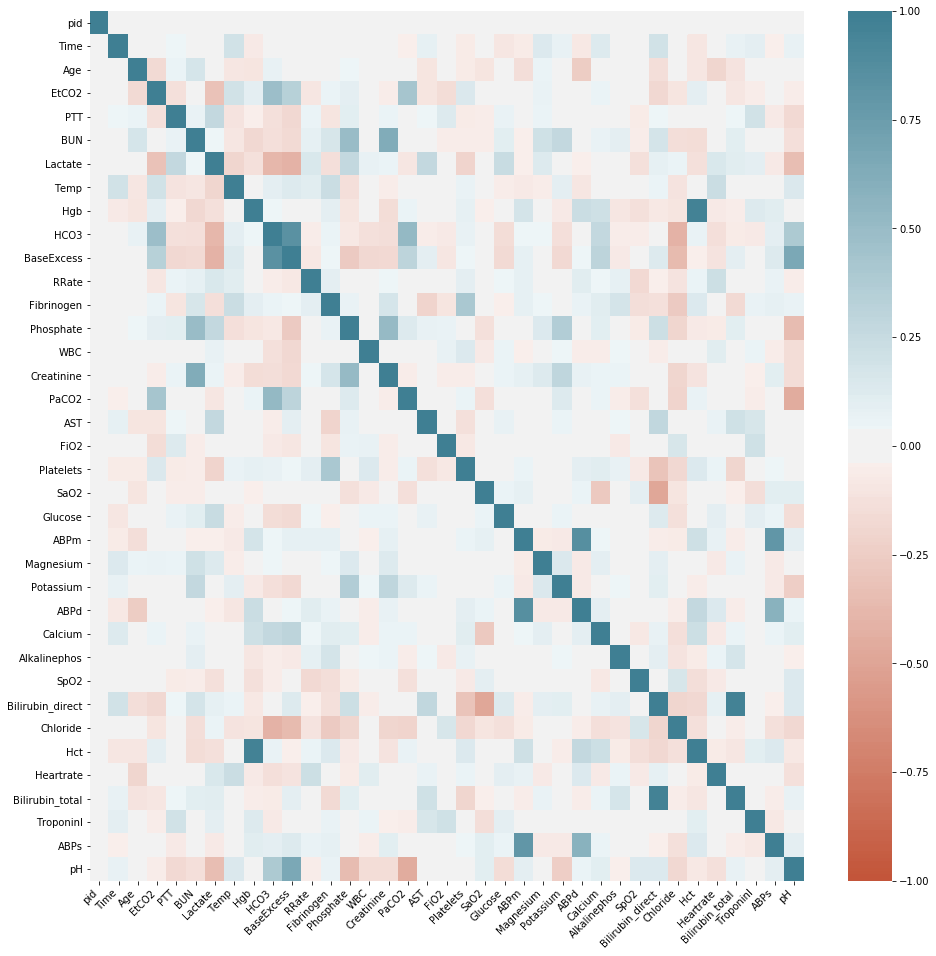

In [5]:
# calculate the correlation matrix
corr = df_train_features.corr()

# plot the heatmap
plt.figure(figsize=(16, 16))
ax = sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, 
        vmin=-1, vmax=1, center=0, 
           cmap=sns.diverging_palette(20, 220, n=200))
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### Visualizing pattern of missing values

Percentage of missing values:
pid                 0.000000
Time                0.000000
Age                 0.000000
EtCO2               0.957081
PTT                 0.954817
BUN                 0.911797
Lactate             0.952812
Temp                0.644139
Hgb                 0.902189
HCO3                0.944902
BaseExcess          0.912753
RRate               0.176165
Fibrinogen          0.989063
Phosphate           0.949153
WBC                 0.916281
Creatinine          0.921944
PaCO2               0.907682
AST                 0.974726
FiO2                0.883294
Platelets           0.920878
SaO2                0.942906
Glucose             0.793647
ABPm                0.140612
Magnesium           0.923125
Potassium           0.875437
ABPd                0.331324
Calcium             0.921778
Alkalinephos        0.974958
SpO2                0.143669
Bilirubin_direct    0.996846
Chloride            0.938944
Hct                 0.880245
Heartrate           0.122015
Bilirubin_tot

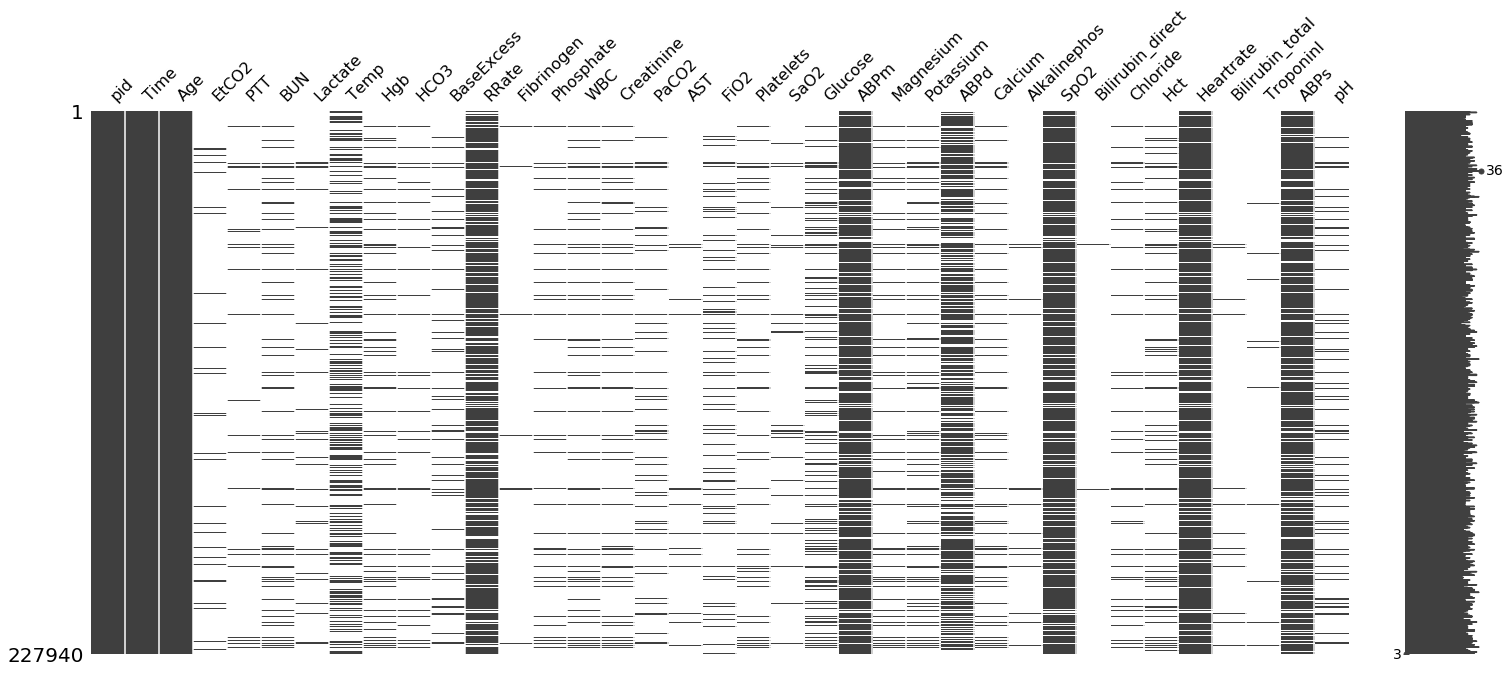

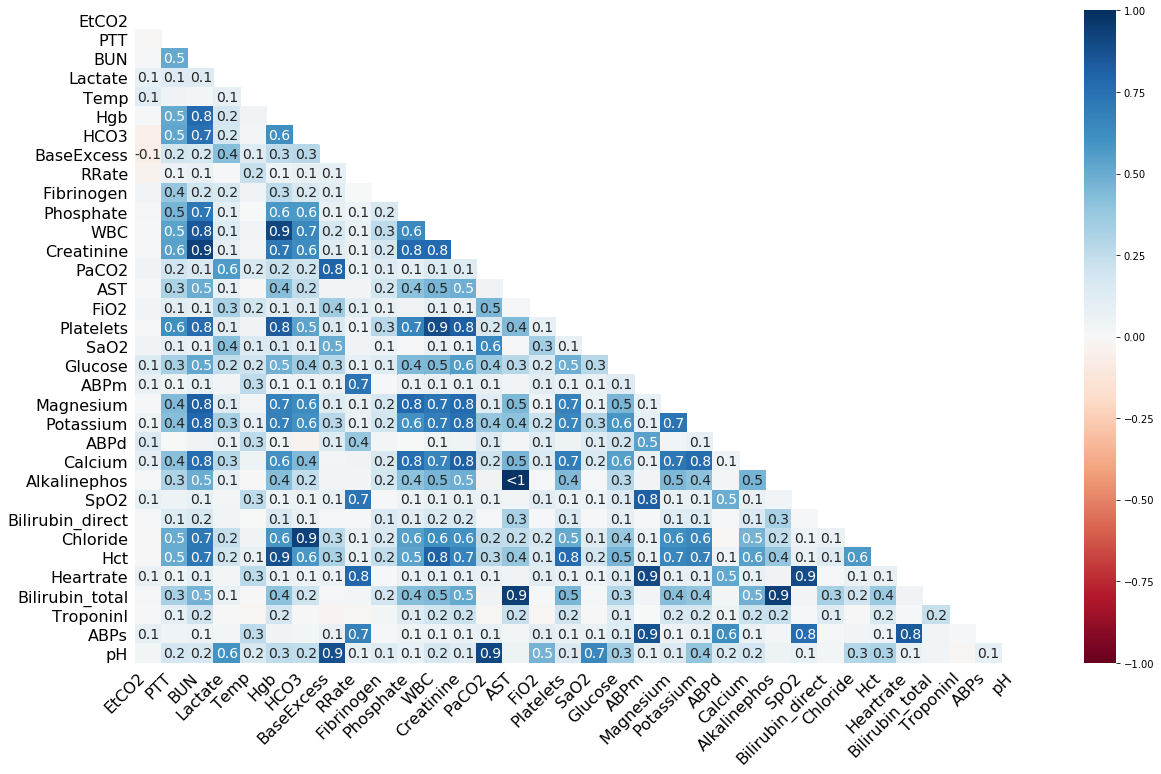

In [6]:
# how much missing data? 
print("Percentage of missing values:")
print(df_train_features.isnull().sum(axis=0) / len(df_train_features))

msno.matrix(df_train_features)

# Plotting the correlation between the missing values
msno.heatmap(df_train_features)

### Train data pre-processing

In [ ]:
# Patient by patient pre-processing for imputation and feature generation

# get variables from train features
variables = df_train_features.columns[2:]

# get all pids, to impute and pre-process individually
train_pids = df_train_features['pid'].unique()

for pid in train_pids:
    # dataframe for this pid
    df = df_train_features.loc[df_train_features['pid'] == pid]
    
    for var in variables:
        # how many NaN are in there for this variable
        data = df[var]
        num_nan = data.isnull().sum(axis=0)
        if num_nan == 12:
            continue
        
        data = data.to_numpy()
           
        imp = SimpleImputer(missing_values = np.nan)
        train_imputed = imp.fit_transform(data.reshape(-1, 1))
    
        df_train_features.loc[df_train_features['pid'] == pid,var] = train_imputed


In [ ]:
# aggregate the time series, for each variable compute: min max mean median
data_array = np.empty([len(train_pids), 4*len(variables)])
i = 0
j = 0

for pid in train_pids:
    
    df = df_train_features.loc[df_train_features['pid'] == pid]
    j = 0
    
    for var in variables:
        # how many NaN are in there for this variable
        data = df[var]
        num_nan = data.isnull().sum(axis=0)
        if num_nan == 12:
            data_array[i, 4*j] = np.nan
            data_array[i, 4*j+1] = np.nan
            data_array[i, 4*j+2] = np.nan
            data_array[i, 4*j+3] = np.nan
            j = j + 1
            continue
        data = data.to_numpy()
        data_array[i, 4*j] = np.min(data)
        data_array[i, 4*j+1] = np.max(data)
        data_array[i, 4*j+2] = np.mean(data)
        data_array[i, 4*j+3] = np.median(data)
        j = j + 1 
        
    i = i +1

In [ ]:
# impute missing data points
#imp = SimpleImputer(strategy="mean")
imputer = KNNImputer(n_neighbors=12)
df_train_agg_imputed_features = imputer.fit_transform(data_array)
#print(df_train_agg_imputed_features)

In [ ]:
# scale the data
min_max_scaler = preprocessing.StandardScaler()
# standard_scalar = preprocessing.StandardScaler()

data_train_scaled = min_max_scaler.fit_transform(df_train_agg_imputed_features)

In [ ]:
# Visualizing the training data after imputing and aggregating

plt.figure(figsize=(16, 16))
ax = sns.boxplot(data = pd.DataFrame(data_train_scaled))
ax.set_xticklabels(
    list(df_train_features),
    rotation=90,
    horizontalalignment='right'
);

In [ ]:
# What is the correlation between the 
pd.DataFrame(data_train_scaled).corrwith(other = pd.DataFrame(df_train_agg_imputed_features), method = "spearman").transpose()

### PCA plot 

In [ ]:
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(data_train_scaled)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, df_train_labels[['LABEL_BaseExcess']]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA for LABEL_BaseExcess', fontsize = 20)
targets = [0, 1]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['LABEL_BaseExcess'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

### Test Data pre-processing

In [ ]:
# data inspection: 
#############################################
# range of the provided data?
print(df_test_features.agg([min, max]))

# how much missing data? 
print("number of missing values:")
print(df_test_features.isnull().sum(axis=0))

In [ ]:
# Patient by patient pre-processing for imputation and feature generation

# get variables from train features
variables = df_test_features.columns[2:]

# get all pids, to impute and pre-process individually
test_pids = df_test_features['pid'].unique()

for pid in test_pids:
    # dataframe for this pid
    df = df_test_features.loc[df_test_features['pid'] == pid]
    
    for var in variables:
        # how many NaN are in there for this variable
        data = df[var]
        num_nan = data.isnull().sum(axis=0)
        if num_nan == 12:
            continue
        
        data = data.to_numpy()
           
        imp = SimpleImputer(missing_values = np.nan)
        test_imputed = imp.fit_transform(data.reshape(-1, 1))
    
        df_test_features.loc[df_test_features['pid'] == pid,var] = test_imputed


In [ ]:
# aggregate the time series, for each variable compute: min max mean median
data_array = np.empty([len(test_pids), 4*len(variables)])
i = 0
j = 0

for pid in test_pids:
    
    df = df_test_features.loc[df_test_features['pid'] == pid]
    j = 0
    
    for var in variables:
        # how many NaN are in there for this variable
        data = df[var]
        num_nan = data.isnull().sum(axis=0)
        if num_nan == 12:
            data_array[i, 4*j] = np.nan
            data_array[i, 4*j+1] = np.nan
            data_array[i, 4*j+2] = np.nan
            data_array[i, 4*j+3] = np.nan
            j = j + 1
            continue
        data = data.to_numpy()
        data_array[i, 4*j] = np.min(data)
        data_array[i, 4*j+1] = np.max(data)
        data_array[i, 4*j+2] = np.mean(data)
        data_array[i, 4*j+3] = np.median(data)
        j = j + 1 
        
    i = i +1

In [ ]:
# impute missing data points
# should we impute it with the same imputer that we've used for train?
df_test_agg_imputed_features = imputer.transform(data_array)

In [ ]:
# scale test data
data_test_scaled = min_max_scaler.transform(df_test_agg_imputed_features)

## Fit a model & Predictdf_test_agg_imputed_features

### predict with support vector machine classification and use probabilities

In [ ]:
# first for the labels that have an output [0,1]

columns_1 = [test_pids]

for i in range(1, 12):
    # feature selection
    transformer = GenericUnivariateSelect(chi2, 'k_best', param=20)
    train_features = transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,i])
    test_features = trasformer.transform(data_test_scaled)
    
    clf = SVC(kernel = 'poly', degree = 5, class_weight = 'balanced', verbose = True)
    clf.fit(train_features, df_train_labels.iloc[:,i])
    # pred = clf.predict(df_test_agg_imputed_features)
    # columns_1.append(pred)
     
    # compute probabilites as opposed to predictions
    dual_coefficients = clf.dual_coef_    # do we have to normalize with norm of this vector ?
    distance_hyperplane = clf.decision_function(test_features)
    probability = np.empty(len(distance_hyperplane))
    for j in range(0, len(probability)):
        if distance_hyperplane[j] < 0:
            probability[j] = 1 - 1/(1 + math.exp(distance_hyperplane[j]))
        else:
            probability[j] = 1/(1 + math.exp(-distance_hyperplane[j]))
    columns_1.append(probability)


    
    distance_hyperplace_train = clf.decision_function(train_features)
    probability = np.empty(len(distance_hyperplace_train))
    for j in range(0, len(probability)):
        if distance_hyperplace_train[j] < 0:
            probability[j] = 1 - 1/(1 + math.exp(distance_hyperplace_train[j]))
        else:
            probability[j] = 1/(1 + math.exp(-distance_hyperplace_train[j]))
      
    tmp = roc_auc_score(y_score= probability, y_true= df_train_labels.iloc[:,i])
    print("ROC AUC for feature", list(df_train_labels)[i] , " : ", tmp)
    

In [ ]:
# labels that have a real value
columns_2 = []

for i in range(12, 16):
    clf_w = SVR('rbf', degree = 3)
    parameters = {'C':np.linspace(1,10, 4)}
    clf = model_selection.GridSearchCV(estimator= clf_w, param_grid = parameters, cv = 5,
                                       refit = True, scoring = 'r2', verbose = 1)
    clf.fit(data_train_scaled, df_train_labels.iloc[:,i])
    pred_train = clf.predict(data_train_scaled)
    tmp = r2_score(y_pred= pred_train, y_true=df_train_labels.iloc[:,i])
    print("R2 for feature", list(df_train_labels)[i] , " : ", tmp)
    
    pred = clf.predict(data_test_scaled)
    columns_2.append(pred)
    

In [ ]:
columns_final = columns_1 + columns_2


### predict with Support vector regression and then compute sigmoid function

In [ ]:
# first for the labels that have an output [0,1]

columns_1 = [test_pids]

for i in range(1,12):
    
    clf = SVR(kernel = 'poly', degree = 3, max_iter = 10000)
    clf.fit(data_train_scaled, df_train_labels.iloc[:,i])
    pred = clf.predict(data_test_scaled)
    prob = np.empty(len(pred))
    for j in range(0, len(pred)):
        prob[j] = 1 / (1 + math.exp(-pred[j]))
    columns_1.append(prob)
    
    pred_train = clf.predict(data_train_scaled)
    prob_train = np.empty(len(pred_train))
    for j in range(0, len(pred_train)):
        prob_train[j] = 1 / (1 + math.exp(-pred_train[j]))    
    tmp = roc_auc_score(y_score= prob_train, y_true= df_train_labels.iloc[:,i])
    print("ROC AUC for feature", list(df_train_labels)[i] , " : ", tmp)


In [ ]:
# labels that have a real value

columns_2 = []

for i in range(12, 16):
    clf_w = LinearSVR()
    parameters = {'C':np.linspace(0.1,10, 20)}
    clf = model_selection.GridSearchCV(estimator= clf_w, param_grid = parameters, cv = 5,
                                       refit = True, scoring = 'r2', verbose = 1, n_jobs=6)
    
    clf.fit(data_train_scaled, df_train_labels.iloc[:,i])
    print(clf.cv_results_)
    pred = clf.predict(data_test_scaled)
    columns_2.append(pred)
    
    pred_train = clf.predict(data_train_scaled)
    tmp = r2_score(y_pred= pred_train, y_true=df_train_labels.iloc[:,i])
    print("R2 for feature", list(df_train_labels)[i] , " : ", tmp)

In [ ]:
columns_final = columns_1 + columns_2

## Save predictions

In [ ]:
print(np.shape(columns_final))
result = pd.DataFrame(columns_final).transpose()
result.columns = list(df_train_labels)
result.to_csv('./Results/prediction.zip', index=False, float_format='%.3f', compression='zip')

In [ ]:
result.to_csv('./Results/prediction.csv', index=False, float_format='%.3f')